# Задача 3. Детектирование токсичных комментариев

Вам будет предоставлен корпус размеченных (0 - не токсик, 1 - токсик) текстов, где тексты представляют собой комментарии. Необходимо выполнить их семантический анализ и классифицировать на позитивные и негативные (токсичные).

Задачу можно решить как минимум двумя способами: классической текстовой моделью TF-IDF или с помощью нейронок типа BERT трансформера (суть таких нейронок в общем схожа - они делают эмбендинги слов - верктоные представления)

В качестве метрики используйте f1-меру

полезные источники:

https://habr.com/ru/companies/otus/articles/755772/

https://habr.com/ru/articles/446530/

https://habr.com/ru/companies/otus/articles/702838/


# Импортируем необходимые библиотеки 

Импорт основных библиотек 

In [498]:
import os
import re
from collections import Counter
import warnings
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns

warnings.filterwarnings('ignore')

Импорт спец. библиотек

In [499]:
import nltk
from tqdm import tqdm
from wordcloud import WordCloud
from nltk.util import bigrams, ngrams
import tensorflow as tf
from nltk.corpus import wordnet
from catboost import CatBoostClassifier
from pymystem3 import Mystem
from sentence_transformers import SentenceTransformer

импорт элементов библиотеки Scikit-Learn

In [500]:
from sklearn.metrics import average_precision_score, precision_score, recall_score, f1_score, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer

## Подготовка данных 

откроем и изучим файл

In [501]:
df = pd.read_csv('toxic_comments.csv',names=['text','toxic'],skiprows=[0])

In [502]:
df.head()

text  toxic
0  Explanation\r\nWhy the edits made under my use...      0
1  D'aww! He matches this background colour I'm s...      0
2  Hey man, I'm really not trying to edit war. It...      0
3  "\r\nMore\r\nI can't make any real suggestions...      0
4  You, sir, are my hero. Any chance you remember...      0

Проверим типы данных

In [503]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [504]:
df.describe()

toxic
count  159292.000000
mean        0.101612
std         0.302139
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000

## Итог
Датасет содержит почти 160 тыс. комментариев.

## Тип данных
Тип данных соответствует содержанию в колонка.

## Пропуски и дубликаты
Пропуски и дубликаты - отсутствуют.


## Рассмотрим распределение позитивных и негативных коментрариев

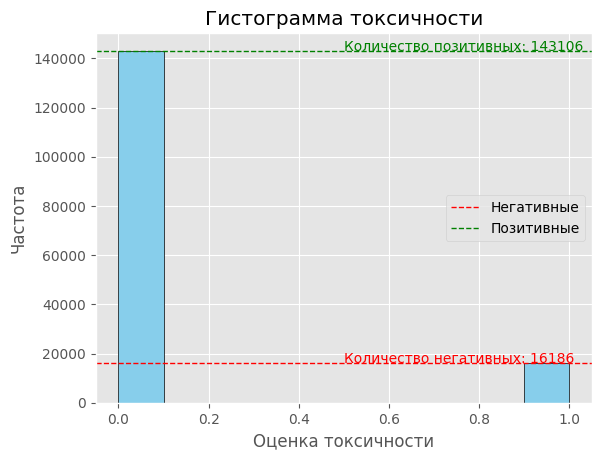

In [505]:
# Используем стиль ggplot для более привлекательного внешнего вида
plt.style.use('ggplot')

# Построение гистограммы
plt.hist(df['toxic'], bins=10, color='skyblue', edgecolor='black')

# Добавление заголовка и меток осей на русском языке
plt.title('Гистограмма токсичности')
plt.xlabel('Оценка токсичности')
plt.ylabel('Частота')

# Добавление уровней для отметки количества токсичных и нетоксичных комментариев
toxic_count = df[df['toxic'] == 1]['toxic'].count()
non_toxic_count = df[df['toxic'] == 0]['toxic'].count()

plt.axhline(toxic_count, color='red', linestyle='--', linewidth=1, label='Негативные')
plt.axhline(non_toxic_count, color='green', linestyle='--', linewidth=1, label='Позитивные')

# Добавление текста с количеством над каждой линией
plt.text(0.5, toxic_count + 10, f'Количество негативных: {toxic_count}', color='red', fontsize=10)
plt.text(0.5, non_toxic_count + 10, f'Количество позитивных: {non_toxic_count}', color='green', fontsize=10)

# Добавление легенды
plt.legend()

# Добавление сетки для лучшей читаемости
plt.grid(True)

# Отображение гистограммы
plt.show()


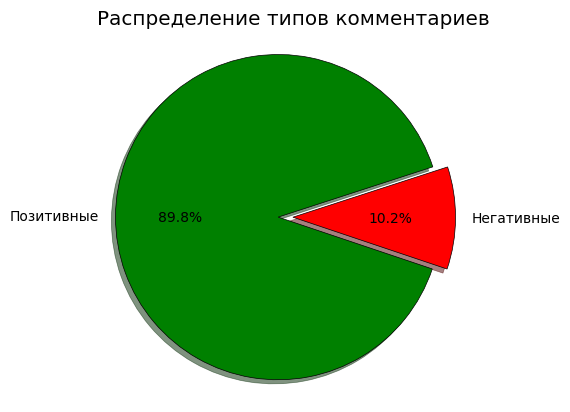

In [506]:
# Используем стиль ggplot для более привлекательного внешнего вида
plt.style.use('ggplot')

# Распределение токсичности комментариев на круговой диаграмме
plt.pie(df['toxic'].value_counts(),
        labels=['Позитивные', 'Негативные'],
        autopct='%1.1f%%',
        startangle=18,
        explode=(0.1, 0),  # добавляем небольшое расстояние между сегментами
        shadow=True,
        colors=['green', 'red'],  # цвета для позитивных и негативных комментариев соответственно
        wedgeprops={'edgecolor': 'black'},  # добавляем черную границу для каждого сегмента
        radius=1.10)
plt.title('Распределение типов комментариев')

# Отображение круговой диаграммы
plt.show()

## Итог 

Присутствует дисбаланс классов: позитивных комментариев больше в 9 раз.


## Длина комментариев

In [507]:
df['comment_length'] = df['text'].str.len()

In [508]:
df['comment_length'].describe()

count    159292.000000
mean        396.211618
std         593.777170
min           5.000000
25%          96.000000
50%         207.000000
75%         437.000000
max        5000.000000
Name: comment_length, dtype: float64

Посмотрим на распределение длины комментариев в обучающей и тестовой выборках:

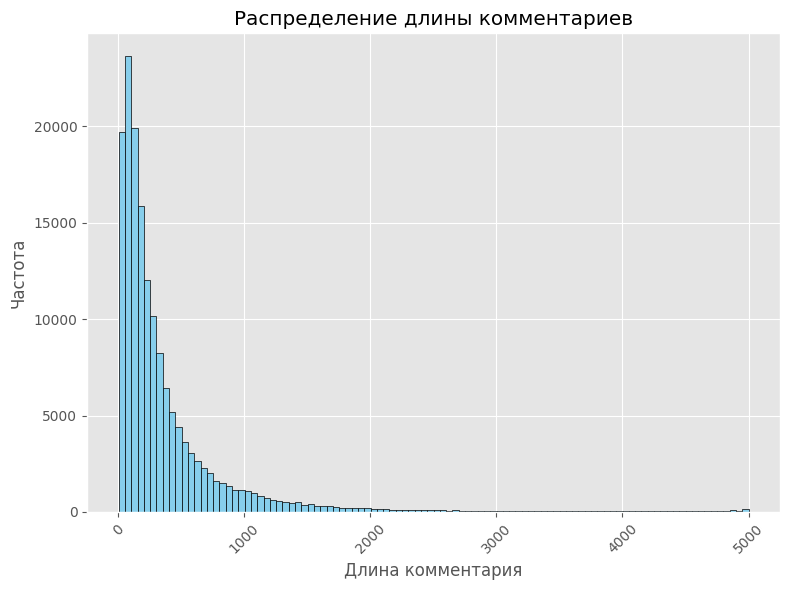

In [509]:
# Используем стиль ggplot для более привлекательного внешнего вида
plt.style.use('ggplot')

# Создание объекта Figure и осей
fig, ax = plt.subplots(figsize=(8, 6))

# Название графика и построение гистограммы
title = 'Распределение длины комментариев'
df['comment_length'].hist(ax=ax, bins=100, color='skyblue', edgecolor='black')

# Установка заголовка и меток осей
ax.set(title=title, xlabel='Длина комментария', ylabel='Частота')

# Добавление сетки для лучшей читаемости
ax.grid(True)

# Уменьшение перекрытия меток оси x
plt.xticks(rotation=45)

# Подгонка макета
plt.tight_layout()

# Отображение графика
plt.show()

## Посмотрим на распределение длины негативных и позитивных комментариев:

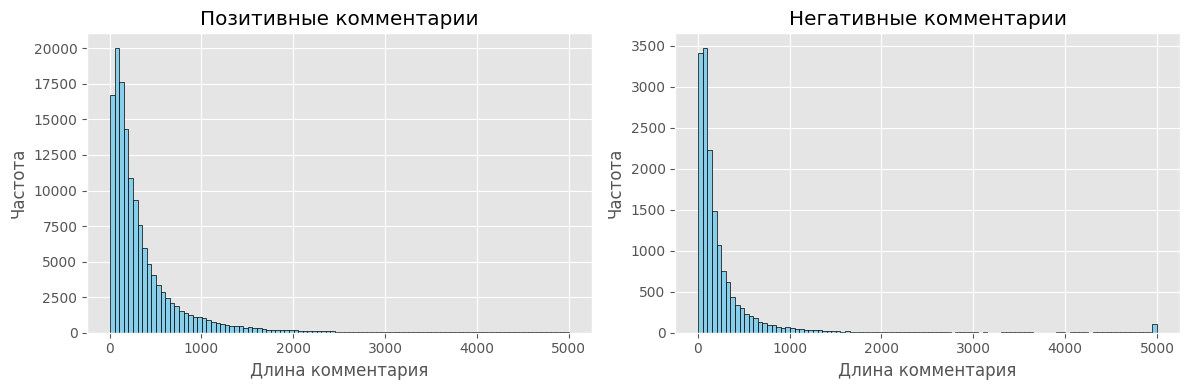

In [510]:
# Используем стиль ggplot для более привлекательного внешнего вида
plt.style.use('ggplot')

# Создание фигуры и осей
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Построение гистограмм для позитивных и токсичных комментариев
for i, title in enumerate(['Позитивные', 'Негативные']):
    df[df['toxic'] == i]['comment_length'].hist(ax=ax[i], bins=100, color='skyblue', edgecolor='black')
    ax[i].set(title=title + ' комментарии', xlabel='Длина комментария', ylabel='Частота')
    ax[i].grid(True)  # Добавление сетки

# Установка отступов между графиками
plt.tight_layout()

# Отображение гистограмм
plt.show()

In [511]:
# Создание фигуры и осей
fig, ax = plt.subplots(figsize=(12, 4))

# Создание ящиковых графиков для позитивных и негативных комментариев
sns.boxplot(y='toxic', x='comment_length', orient='h', data=df, ax=ax, palette=['lightblue', 'orange'])

# Установка заголовка и меток осей
ax.set(title='Позитивные и Негативные комментарии', xlabel='Длина комментария', ylabel='Токсичность')

# Добавление легенды

legend_elements = [Patch(facecolor='lightblue', label='Позитивные'),
                   Patch(facecolor='orange', label='Негативные')]
ax.legend(handles=legend_elements)

# Подгонка макета
plt.tight_layout()

# Отображение графика
plt.show()

## Итог:

Отсутствуют серьезные различия в длине позитивных и негативных комментариев.

# TF-IDF (CPU)

Самый примитивны способ: использовать только слова встречаемые в исходном тексте. Обучение и предсказание происходит только на словаре, который сформировывается из слов комментариев.

Оцифровка слов происходит за счёт подсчёта их важности, величиной TF-IDF. То есть TF отвечает за количество упоминаний слова в отдельном тексте, а IDF отражает частоту его употребления во всём корпусе.

Примечание: бóльшая величина TF-IDF говорит об уникальности слова в тексте по отношению к корпусу. Чем чаще оно встречается в конкретном тексте и реже в остальных, тем выше значение TF-IDF.

In [512]:
# инициализация класса для лемматизации
WNLemmatizer = nltk.stem.WordNetLemmatizer()
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# функция определение части речи
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

# функция лемматизации и очистки текста
def lemm_clear_text(text):
    word_list = nltk.word_tokenize(text)
    lemm_text = ' '.join([WNLemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in word_list])
    lemm_text = re.sub(r"[a-zA-Z]+'?[a-zA-Z]+", '', lemm_text)
    lemm_text = lemm_text.split()
    lemm_clear_text =  ' '.join(lemm_text)
    return lemm_clear_text

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [513]:
# df['lemm_text'] = ""

# for index, row in tqdm(df.iterrows(), total=len(df)):

#     df.at[index, 'lemm_text'] = lemm_clear_text(row['text'])

In [514]:
# df.to_csv('test_preprocessed.csv', index=False)

In [515]:
read_test_df = pd.read_csv('test_preprocessed.csv')



In [516]:
print('Исходный текст:', read_test_df.loc[1, 'text'])
print('Лемматизированный:', read_test_df.loc[1, 'lemm_text'])

Исходный текст: D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)
Лемматизированный: Daww He match this background colour I m seemingly stuck with Thanks talk January UTC


После лемматизации теста появились пропусти. Это комментарии состоящие только из цифр и символов. Для них не существуют леммы, и следовательно результатом лемматизации будет: NaN. Пример этих объектов приведён ниже. В дальнейгей работе они использованы не будут.

In [517]:
read_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   text            159292 non-null  object
 1   toxic           159292 non-null  int64 
 2   comment_length  159292 non-null  int64 
 3   lemm_text       159281 non-null  object
dtypes: int64(2), object(2)
memory usage: 4.9+ MB


In [518]:
anomaly_index = read_test_df[(read_test_df['lemm_text'].isna()) | (read_test_df['lemm_text']=='')].index
display(read_test_df.loc[anomaly_index])
read_test_df.drop(index=anomaly_index, inplace=True)
read_test_df.reset_index(drop=True, inplace=True)

text  toxic  \
4475    1993\n\n1994\n\n1995\n\n1996\n\n1997\n\n1998\n...      0   
6289                                 193.61.111.53  15:00      0   
10193                                      64.86.141.133"      0   
17280                                ~ \n\n68.193.147.157      0   
38743                                       88.104.31.21"      0   
52336                                              14:53,      0   
53679                       92.24.199.233|92.24.199.233]]      0   
61644                            "\n\n 199.209.144.211  "      0   
82541                              "\n '''''' 2010/2013 "      0   
119018                                                """      1   
137400                                             == """      0   

        comment_length lemm_text  
4475                64       NaN  
6289                20       NaN  
10193               14       NaN  
17280               18       NaN  
38743               13       NaN  
52336                6       NaN  
53679               29       NaN  
61644               22       NaN  
82541               21       NaN  
119018               5       NaN  
137400               6       NaN

## Биграммы и триграммы

In [519]:
read_test_df['toxic'] = read_test_df['toxic'].map({0: 'Позитивные', 1: 'Негативные'})

In [520]:
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')

# создание TF-IDF векторизатора с стоп словами (слова без смысловой нагрузки)
count_tf_idf = TfidfVectorizer(stop_words=stop_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [521]:
for n, name in zip([2, 3], ['Биграммы', 'Триграммы']):
    for is_clear, title in enumerate(['Негативные', 'Позитивные']):
        all_ngrams = []

        # Извлечение n-грамм из комментариев
        for words_list in read_test_df[read_test_df['toxic'] == title]['lemm_text']:
            all_ngrams.extend((list(ngrams(words_list.split(), n))))

        # Вывод наиболее часто встречающихся n-грамм
        print('{} - {} комментарии:'.format(name, title))
        print(pd.Series(all_ngrams).value_counts()[:10])
        print('\n')

Биграммы - Негативные комментарии:
(be, a)             5252
(do, nt)            2922
(I, be)             2284
(you, be)           2231
(FUCK, YOU)         1885
(NIGGER, NIGGER)    1882
(of, the)           1590
(moron, hi)         1474
(hi, moron)         1472
(I, m)              1423
Name: count, dtype: int64


Биграммы - Позитивные комментарии:
(of, the)         47822
(in, the)         33908
(be, a)           30776
(do, nt)          28964
(to, the)         25238
(it, be)          24743
(be, not)         23868
(the, article)    22716
(on, the)         21251
(to, be)          20135
Name: count, dtype: int64


Триграммы - Негативные комментарии:
(NIGGER, NIGGER, NIGGER)    1876
(hi, moron, hi)             1468
(moron, hi, moron)          1466
(faggot, faggot, faggot)    1334
(PIG, PIG, PIG)             1248
(FAT, JEW, FAT)             1226
(JEW, FAT, JEW)             1224
(SHIT, SHIT, SHIT)           998
(Bark, Bark, Bark)           998
(WANKER, WANKER, WANKER)     940
Name: count, dtype

## Облако слов  

Разделим позитивные и негативные комметарии 

In [522]:
toxic_text = " ".join(read_test_df[read_test_df['toxic'] == 'Негативные'].text.tolist())
clear_text = " ".join(read_test_df[read_test_df['toxic'] == 'Позитивные'].text.tolist())

In [534]:

# Define function to clean and tokenize text
def clean_and_tokenize(text):
    # Convert text to lowercase and split into words
    words = re.findall(r'\b\w+\b', text.lower())
    return words

# Tokenize toxic and clear text
toxic_words = clean_and_tokenize(toxic_text)
clear_words = clean_and_tokenize(clear_text)

# Count occurrences of each word
toxic_word_counts = Counter(toxic_words)
clear_word_counts = Counter(clear_words)

# Print the count of each word in toxic text
print("Word counts in toxic text:")
for word, count in toxic_word_counts.items():
    print(f"{word}: {count}")

# Print the count of each word in clear text
print("\nWord counts in clear text:")
for word, count in clear_word_counts.items():
    print(f"{word}: {count}")


Word counts in toxic text:
cocksucker: 550
before: 552
you: 40577
piss: 175
around: 404
on: 5385
my: 6584
work: 534
hey: 826
what: 3812
is: 13828
it: 9117
talk: 1539
an: 3557
exclusive: 11
group: 95
of: 12641
some: 1430
wp: 301
talibans: 2
who: 2618
are: 8761
good: 864
at: 1734
destroying: 21
self: 273
appointed: 17
purist: 1
gang: 31
up: 2535
any: 990
one: 1701
asks: 9
them: 969
questions: 60
abt: 1
their: 921
anti: 268
social: 49
and: 17461
destructive: 11
non: 167
contribution: 60
ask: 207
sityush: 2
to: 17499
clean: 61
his: 1512
behavior: 100
than: 970
issue: 110
me: 5917
nonsensical: 8
warnings: 83
bye: 77
don: 2840
t: 6261
look: 597
come: 697
or: 2609
think: 1397
comming: 3
back: 769
tosser: 16
gay: 2262
antisemmitian: 1
archangel: 2
white: 243
tiger: 8
meow: 4
greetingshhh: 1
uh: 27
there: 1512
two: 326
ways: 43
why: 1910
do: 4328
erased: 14
comment: 398
about: 2533
ww2: 8
that: 9263
holocaust: 32
was: 2743
brutally: 6
slaying: 2
jews: 252
not: 5427
gays: 32
gypsys: 2
slavs: 7
a

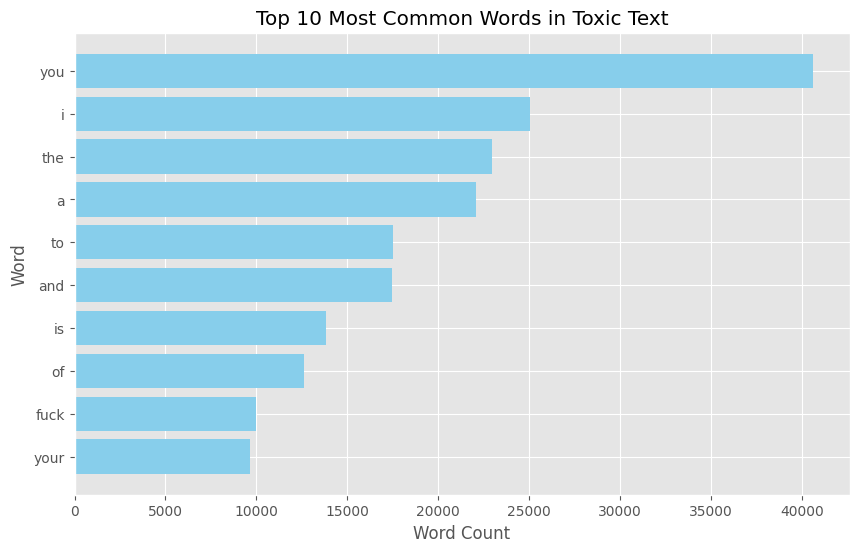

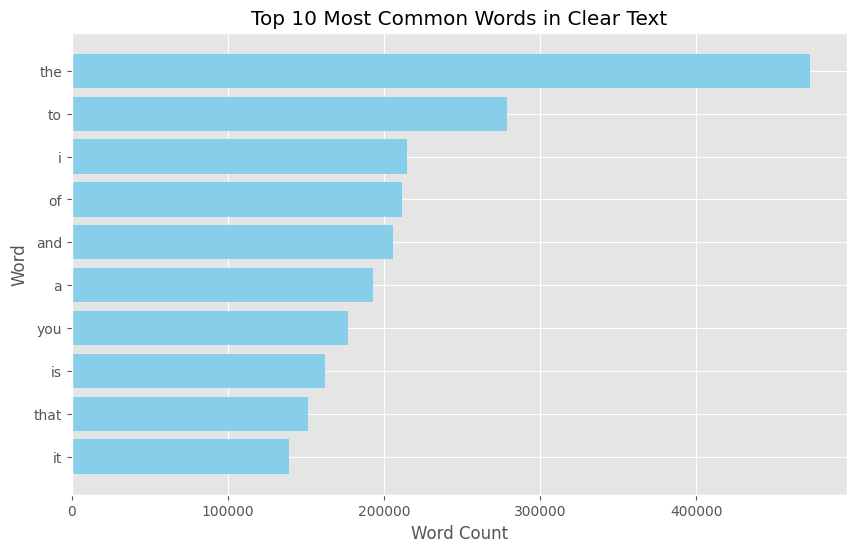

In [538]:
import matplotlib.pyplot as plt

# Define function to plot word counts
def plot_word_counts(word_counts, title):
    # Sort word counts by frequency in descending order
    sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
    
    # Get top 10 most common words and their counts
    top_words = [word[0] for word in sorted_word_counts[:10]]
    top_counts = [word[1] for word in sorted_word_counts[:10]]
    
    # Plot bar chart
    plt.figure(figsize=(10, 6))
    plt.barh(top_words, top_counts, color='skyblue')
    plt.xlabel('Word Count')
    plt.ylabel('Word')
    plt.title(title)
    plt.gca().invert_yaxis()  # Invert y-axis to have the most common word on top
    plt.show()

# Plot word counts for toxic text
plot_word_counts(toxic_word_counts, 'Top 10 Most Common Words in Toxic Text')

# Plot word counts for clear text
plot_word_counts(clear_word_counts, 'Top 10 Most Common Words in Clear Text')


Зададим параметры для построения облака слов.

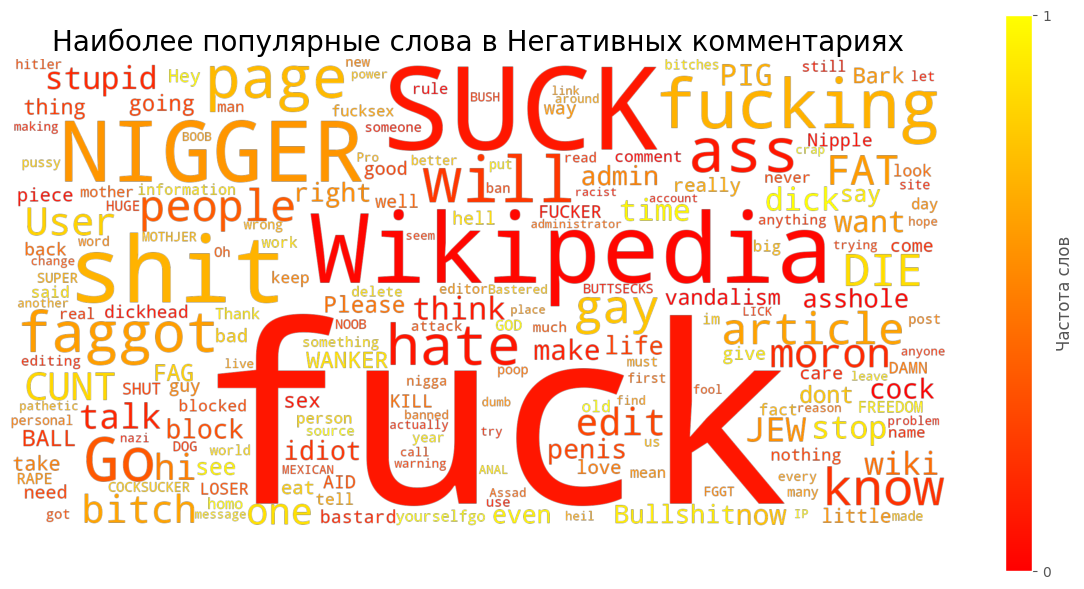

In [546]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import matplotlib.cm as cm
import numpy as np

cloud_params = {
    'max_words': 200,
    'regexp': "[a-zA-Z]+'?[a-zA-Z]+",
    'collocations': False,
    'width': 2400,
    'height': 1200,
    'margin': 5,
    
    'relative_scaling': 1,
    'prefer_horizontal': 1,
    'min_font_size': 20,
    'font_step': 2,

    'background_color': None,
    'mode': 'RGBA',

    'random_state': 42
}

texts = [toxic_text, clear_text]
cmaps = ['autumn', 'winter']
titles = ['Негативных', 'Позитивные']

for text, cmap, title in zip(texts, cmaps, titles):
    word_cloud = WordCloud(colormap=cmap, **cloud_params)
    word_cloud.generate(text)
    
    # Получаем частоты слов
    frequencies = word_cloud.words_
    
    plt.figure(figsize=(12, 6))
    plt.axis('off')
    plt.title('Наиболее популярные слова в {} комментариях'.format(title), fontsize=20)
    plt.imshow(word_cloud, interpolation='bilinear', cmap=cmap)
    
    # Визуализируем цветовую шкалу с числовыми метками
    cb = plt.colorbar(cm.ScalarMappable(cmap=cmap), ax=plt.gca(), orientation='vertical')
    cb.set_label('Частота слов')
    
    # Определяем максимальное значение частоты для меток
    max_freq = max(frequencies.values())
    # Устанавливаем метки шкалы в соответствии с максимальным значением частоты
    cb.set_ticks([0, max_freq])
    
    plt.tight_layout()
    plt.show()


## Построение модели

In [524]:
RANDOM_STATE = 42
FIG_SIZE = (7, 6)

In [525]:
read_test_df['toxic'] = read_test_df['toxic'].replace({'Позитивные': 0, 'Негативные': 1})

In [526]:
# подготовка обучающей выборки
target = read_test_df['toxic']
features = read_test_df['lemm_text']

# выделение тренировочной выборки
X_train_tfidf, X_other, Y_train_tfidf, Y_other = train_test_split(features,
                                                                  target,
                                                                  stratify = target,
                                                                  train_size = 0.80,
                                                                  random_state = RANDOM_STATE)
# выделение валидационной и тестовой выборок
X_valid_tfidf, X_test_tfidf, Y_valid_tfidf, Y_test_tfidf = train_test_split(X_other,
                                                                            Y_other,
                                                                            stratify = Y_other,
                                                                            test_size = 0.50,
                                                                            random_state = RANDOM_STATE)

In [527]:
# "кодирование" текста
count_tf_idf.fit(X_train_tfidf)
X_train_tfidf = count_tf_idf.transform(X_train_tfidf)
X_valid_tfidf = count_tf_idf.transform(X_valid_tfidf)
X_test_tfidf  = count_tf_idf.transform(X_test_tfidf)

print('Количество признаков:', X_train_tfidf.shape[1])

Количество признаков: 169062


Далее следует тестирование преобразованного текста. Поскольку в датасете присутствует дисбаланс, а целевая метрика F1 демонстрирует условную параллельность Recall и Precision. В дополнении к ней будет выводится значение этих метрик и применяться построение PR-кривой и значения порогов классификации.

Для оценки качества преобразования, закодированный текст сразу будет тестироваться на следующих моделях классификации:

LogisticRegression;
CatBoostClassifier.

## LogisticRegression

In [528]:
# объявление модели Логистической регрессии и её гиперпараметров
LogRer_tfidf = LogisticRegression(C = 11.5,
                                  solver = 'sag',
                                  random_state = RANDOM_STATE)

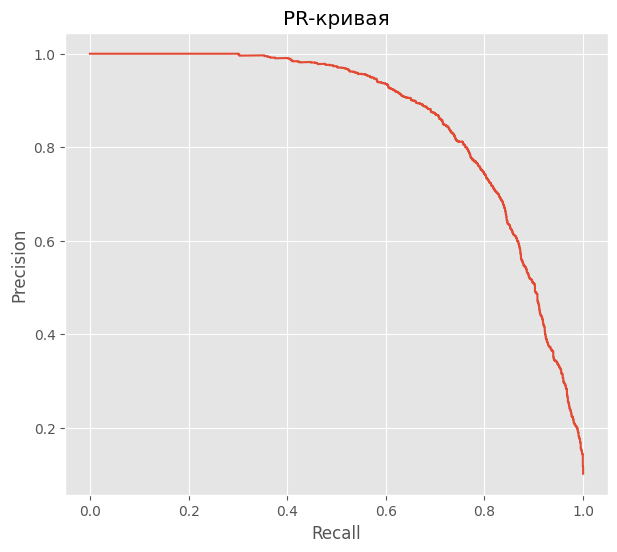

F1 = 0.773
Recall = 0.691
Precision = 0.878


In [529]:
# тестирование TF-IDF на Logistic Regression
LogRer_tfidf.fit(X_train_tfidf, Y_train_tfidf)
prediction_valid = LogRer_tfidf.predict(X_valid_tfidf)
proba_valid = LogRer_tfidf.predict_proba(X_valid_tfidf)
precision, recall, thresholds = precision_recall_curve(Y_valid_tfidf, proba_valid[:, 1])

# PR-кривая
plt.figure(figsize=FIG_SIZE)
plt.plot(recall, precision)
plt.title('PR-кривая')
plt.xlabel('Recall')
plt.ylabel('Precision')
# plt.grid()
plt.show()

# метрики
print('F1 = {:.3f}'.format(f1_score(Y_valid_tfidf, prediction_valid)))
print('Recall = {:.3f}'.format(recall_score(Y_valid_tfidf, prediction_valid)))
print('Precision = {:.3f}'.format(precision_score(Y_valid_tfidf, prediction_valid)))

## CatBoost


In [530]:
# модель градиентного бустинга CatBoost (CPU) 16 minutes
CatBoost_tfidf = CatBoostClassifier(verbose = 100, # шаг вывода информации о процессе обучения
                                    task_type = 'CPU', # среда работы модели
                                    max_depth = 3, # макс. глубина базовых моделей
                                    learning_rate = 0.9, # шаг градиентного бустинга
                                    eval_metric = 'F1') # метрика оценки модели

In [531]:
# обучение CatBoost на фичах TF-IDF
CatBoost_tfidf.fit(X_train_tfidf, Y_train_tfidf)

0:	learn: 0.4062195	total: 243ms	remaining: 4m 2s
100:	learn: 0.7767888	total: 22.2s	remaining: 3m 17s
200:	learn: 0.8047257	total: 43.9s	remaining: 2m 54s
300:	learn: 0.8229351	total: 1m 5s	remaining: 2m 31s
400:	learn: 0.8356913	total: 1m 27s	remaining: 2m 10s
500:	learn: 0.8420790	total: 1m 48s	remaining: 1m 48s
600:	learn: 0.8452272	total: 2m 10s	remaining: 1m 26s
700:	learn: 0.8448820	total: 2m 31s	remaining: 1m 4s
800:	learn: 0.8465503	total: 2m 52s	remaining: 42.8s
900:	learn: 0.8486938	total: 3m 13s	remaining: 21.2s
999:	learn: 0.8580768	total: 3m 33s	remaining: 0us


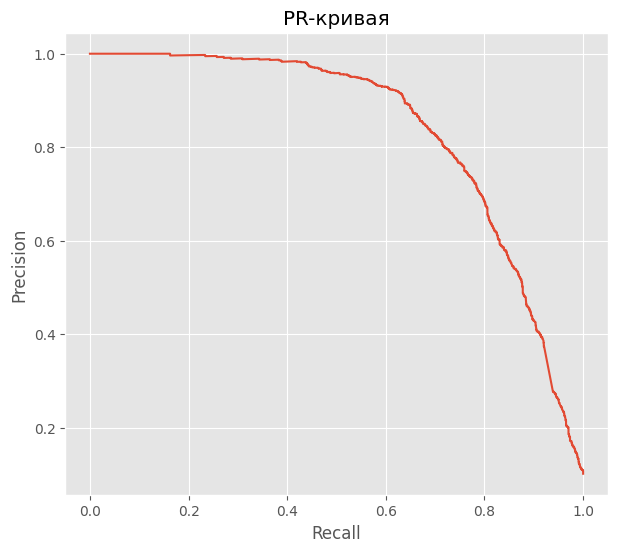

F1 = 0.752
Recall = 0.671
Precision = 0.856


In [532]:
# тестирование TF-IDF на CatBoost
prediction_valid = CatBoost_tfidf.predict(X_valid_tfidf)
proba_valid = CatBoost_tfidf.predict_proba(X_valid_tfidf)
precision, recall, thresholds = precision_recall_curve(Y_valid_tfidf, proba_valid[:, 1])

# PR-кривая
plt.figure(figsize=FIG_SIZE)
plt.plot(recall, precision)
plt.title('PR-кривая')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

# метрики
print('F1 = {:.3f}'.format(f1_score(Y_valid_tfidf, prediction_valid)))
print('Recall = {:.3f}'.format(recall_score(Y_valid_tfidf, prediction_valid)))
print('Precision = {:.3f}'.format(precision_score(Y_valid_tfidf, prediction_valid)))

## Итог:

Лемматизация текста занимает около 5 часов. На этот процесс не влияет применение графического процессора.

Процесс векторизации подготовленного текста с помощью TfidfVectorizer - мгновенный. Слова, не имеющие смысловой нагрузки - удалены.

Логистическая регрессия имеет значение целевой метрики F1 = 0.773

Градиентный бустинг CatBoost F1 = 0.752. Время обучения на CPU 3.5 минут

Ключевым недостатком является большое количество признаков и объём памяти, которую они занимают. Это затрудняет использование GPU, к примеру для ускорения обучения модели CatBoost.


На данном этапе результат тестирования - приемлемый. Но необходимо учесть присутствующий дисбалланс классов. Этой теме будет посвящен отдельный раздел.